In [1]:
import csv
import folium
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from os import path
from time import sleep, time
from datetime import datetime
from shapely.geometry import Point
from difflib import get_close_matches
from geopy.geocoders import Nominatim
%matplotlib inline

In [ ]:
# Read the csv file
print('Reading sample.tsv file...')
df = pd.read_csv(
    path.join('data', 'sample.tsv'),
    sep="\t",
    encoding='utf-8',
    escapechar='\\',
    na_values='N',
    quoting=csv.QUOTE_NONE,
    header=None
)
print('is done!')

In [ ]:
print('Reading schema.txt file...')
schema = pd.read_csv(
    path.join('data', 'schema.txt'),
    sep="\s+",
    header =None
)
print('is done!')
# Rename the dataframe columns
df.columns = schema[1]

In [ ]:
# Drop rows with NaN values in important columns
df.dropna(
    subset=['createdAt', 'id', 'placeLatitude', 'placeLongitude', 'userId'],
    how='any',
    inplace=True
)

In [ ]:
# Change the string in 'createdAt' column to datetime format
df['createdAt'] = pd.to_datetime(
    df['createdAt'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)

In [ ]:
# Remove useless columns
df = df[['id', 'userId', 'createdAt','placeLatitude','placeLongitude']]
# Remove duplicated tweets with the same id
if not df['id'].is_unique:
    df.drop_duplicates(subset='id', inplace=True)
# Reset index
df.reset_index(drop=True, inplace=True)

In order to recover the cities location from latitude-longitude pairs, we use two different strategies:

1. **online strategy:** we use the geopy API to send a request containing information about the longitude and latitude of a place. The main cumbersome here is that all these kind of online APIs have some kind of request rate limit, and as it is suggested in [its website](http://wiki.openstreetmap.org/wiki/Nominatim_usage_policy), the time between two consecutive request should be more that 1 seconds. This actually makes the online approach so slow. One remedy to accelerate the process is to save longitude-latitude: location pair to a dictionary. Thus, before sending a request, we first check whether we have the location in our dictionary or not.

2. **offline strategy:** we can also use the geojson or topojson files for Switzerland and its neighbor countries. The corresponding geofiles are downloaded from the following github repositories:
    1. Switzerland topojson file from [swiss_map repo](https://github.com/d-qn/swiss-maps).
    2. France geojson file from [france-geojson repo](https://github.com/gregoiredavid/france-geojson).
    3. Italy geojson file from [leaflet-geojson-selector repo](https://github.com/stefanocudini/leaflet-geojson-selector).
    4. Germany geojson file from [deutschlandGeoJSON repo](https://github.com/isellsoap/deutschlandGeoJSON)
    5. Austria geojson file from [click_that_hood repo](https://github.com/codeforamerica/click_that_hood).
    6. Liechtenstein geojson file from [CountryGeoJSONCollection repo](https://github.com/LonnyGomes/CountryGeoJSONCollection).

In general, for the offinle strategy, one can also follow this [stackoverflow response](http://stackoverflow.com/questions/6159074/given-the-lat-long-coordinates-how-can-we-find-out-the-city-country/6355183#6355183) or this [one](http://stackoverflow.com/a/24871449/5267664). The first one relies on the geoname database while the second one actually gives us a procedure to find geojson files for any country.

## 1. Online strategy:
We start from the online strategy. The following function find the country together with its state/canton of a location. We will see later that we could do the same thing in the offline approach.

In [ ]:
# Function for finding a location from the latitude-longitude information using online API
geolocator = Nominatim()
locations = dict()
def online_locating(data):
    lat = str(data.placeLatitude)
    lng = str(data.placeLongitude)
    lookup = ','.join([lat, lng])
    if lookup not in set(locations.keys()):
        location = geolocator.reverse(lookup, language='en')        
        try:
            country = location.raw['address']['country_code'].upper()
        except:
            country = float('NaN')
        try:
            state = location.raw['address']['state']
        except:
            try:
                state = location.raw['address']['country']
            except:
                state = float('NaN')
        locations[lookup] = {'country': country, 'state': state}
        sleep(1) # sleep for 1 sec (required by Nominatim usage policy)
    return pd.Series({'country': locations[lookup]['country'],
                      'state': locations[lookup]['state']})

In [ ]:
t = time()
df[['country', 'state']] = df.apply(lambda x: online_locating(x), axis=1)
elapsed = time() - t
print('Elapsed time is ' + str(round(elapsed, 4)) + ' seconds.')

As we can see, it took very long to even recover locations for the sample file. Hence, it does not make sense to follow the online approach for the actual problem.

## 2. Offline approach:
As we mentioned before, it is necessary to download the required geojson/topojson file to run the offline approach. All files are available in data/geofiles folder. In this part, we use [gepandas](http://geopandas.org/) for furthur analysis. The resulting dataframes can be used to find the location of tweets.

In [ ]:
ch_gdf = gpd.read_file(path.join('data/geofiles', 'ch-cantons.json'))
fr_gdf = gpd.read_file(path.join('data/geofiles', 'france-states.geojson'))
it_gdf = gpd.read_file(path.join('data/geofiles', 'italy-states.json'))
de_gdf = gpd.read_file(path.join('data/geofiles', 'germany-states.geojson'))
at_gdf = gpd.read_file(path.join('data/geofiles', 'austria-states.geojson'))
li_gdf = gpd.read_file(path.join('data/geofiles', 'liechtenstein.geojson'))

In [ ]:
# Modify dataframes for merging
ch_gdf = ch_gdf[['geometry', 'name']]
ch_gdf['country'] = 'CH'

fr_gdf = fr_gdf[['geometry', 'name']]
fr_gdf['country'] = 'FR'

it_gdf = it_gdf[['geometry', 'name']]
it_gdf['country'] = 'IT'

de_gdf = de_gdf[['geometry', 'NAME_1']]
de_gdf = de_gdf.rename(columns={'NAME_1': 'name'})
de_gdf['country'] = 'DE'

at_gdf = at_gdf[['geometry', 'name']]
at_gdf['country'] = 'AT'

li_gdf = li_gdf[['geometry', 'NAME']]
li_gdf = li_gdf.rename(columns={'NAME': 'name'})
li_gdf['country'] = 'LI'

gdf_poly = pd.concat([ch_gdf, fr_gdf, it_gdf, de_gdf, at_gdf, li_gdf], ignore_index=True)
gdf_poly = gdf_poly.rename(columns={'name': 'state'})

The R-tree structure in geopandas dataframe enables us to find the twitters location very fast. The following function find each location is inside which state/canton. A tutorial to show how to take advantages of R-tree structure is available [here](http://geoffboeing.com/2016/10/r-tree-spatial-index-python/#more-2183).

In [ ]:
gdf_point = gpd.GeoDataFrame(df)
gdf_point['geometry'] = df.apply(lambda row: Point(row.placeLongitude, row.placeLatitude), axis=1)
gdf_point.crs = gdf_poly.crs

In [ ]:
t = time()
gdf_join = gpd.tools.sjoin(gdf_point, gdf_poly, how="left")
elapsed = time() - t
print('Elapsed time is ' + str(round(elapsed, 4)) + ' seconds.')

In [ ]:
gdf_join.drop_duplicates(subset='id', inplace=True)
gdf_join.reset_index(drop=True, inplace=True)

In [ ]:
null_index = gdf_join['state'].isnull()
gdf_join.loc[null_index,['country', 'state']] = gdf_join[null_index].apply(
    lambda row: online_locating(row), axis=1)

In [ ]:
def modify_dataframe(row):
    countries = set(gdf_poly['country'].unique())
    if row['country'] not in countries:
        row['state'] = row['country']
    else:
        sub_gdf = gdf_poly[gdf_poly['country'] == row['country']]
        indices = sub_gdf.index
        states = sub_gdf.state.values
        if 'Bavaria' in row['state']:
            row['state'] = 'Bayern'
        else:
            row['state'] = get_close_matches(row['state'], states, 1, 0)[0]
        row['index_right'] = sub_gdf[sub_gdf['state'] == row['state']].index.values[0]
    return row

In [ ]:
gdf_join.loc[null_index,:] = gdf_join[null_index].apply(
    lambda row: modify_dataframe(row), axis=1)

In [ ]:
# Remove tweets from countries which are not in our list
gdf_join = gdf_join[gdf_join['index_right'].notnull()]
# Reset index
gdf_join.reset_index(drop=True, inplace=True)
# Convert float number in the index_right column to integer
gdf_join['index_right'] = gdf_join['index_right'].astype(int)

In [6]:
cantons_topo = 'data/geofiles/ch-districts1.json'

main_map = folium.Map(location=[46.50,8.20], zoom_start=8)
main_map.choropleth(geo_path=cantons_topo,
                     topojson='feature',
                     fill_color='YlGnBu',
                     legend_name = 'Random numbers'
                    )
main_map

TypeError: 'NoneType' object is not subscriptable

In [1]:
from topojson import geojson
geojson('data/geofiles/ch-districts1.json')

ImportError: cannot import name 'convert'

In [3]:
sd = gpd.read_file('data/geofiles/ch-districts1.json')

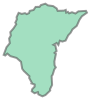

In [7]:
sd['geometry'][0]